# batch MCX sim

## setup

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 25 19:50:49 2025

@author: zhiguan wang
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pmcx
from scipy.optimize import curve_fit
from cv2 import resize
import cv2
import os
from tqdm import tqdm
from scipy.signal import fftconvolve
from torchvision import datasets, transforms
import torchvision
import torch
import collections
from torch.utils.data import DataLoader,Subset
import pickle
import json

from datetime import datetime

import ipywidgets as widgets
from IPython.display import display

# create an output widget for logging
disp_region = widgets.Output(layout={'border': '1px solid black', 'height': '800px', 'overflow_y': 'scroll'})

## get dataset

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import collections
import random

# ================= 配置区域 =================
ROOT = "F:/OneDrive/foam_imaging_project/pmcx_foam/MNIST_img_dataset"
SPLIT = "byclass"
NUM_TOTAL = 500      # 总共需要的样本数
RANDOM_SEED = 42
BATCH_SIZE = 64

# 【新增功能】在这里定义你想要的字母
# 选项 1: 选择全部字母
# TARGET_LETTERS = 'ALL' 

# 选项 2: 只选择特定字母 (例如只选 X 和 Y)
TARGET_LETTERS = ['L', 'Z'] 
# TARGET_LETTERS = ['A', 'B', 'C'] # 也可以这样选
# ===========================================

transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.EMNIST(root=ROOT, split=SPLIT, train=True, download=True, transform=transform)
test_ds  = datasets.EMNIST(root=ROOT, split=SPLIT, train=False, download=True, transform=transform)

class ConcatDatasetLike(torch.utils.data.Dataset):
    def __init__(self, ds1, ds2):
        self.ds1 = ds1
        self.ds2 = ds2
        self.len1 = len(ds1)
        self.len2 = len(ds2)
    def __len__(self):
        return self.len1 + self.len2
    def __getitem__(self, idx):
        if idx < self.len1:
            return self.ds1[idx]
        else:
            return self.ds2[idx - self.len1]

full_ds = ConcatDatasetLike(train_ds, test_ds)

# ---------------------------------------------------------
# 1. 解析目标 Label
# EMNIST byclass 映射: 0-9是数字, 10-35是A-Z, 36-61是a-z
# ---------------------------------------------------------
target_labels_list = []

if TARGET_LETTERS == 'ALL':
    # 如果是 ALL，则包含 10 到 35 (即 A-Z)
    target_labels_list = list(range(10, 36))
else:
    # 如果是列表，将字符转换为对应的 label
    # ord('A') = 65, EMNIST中 'A' = 10. 偏移量 = 10 - 65 = -55
    # 公式: label = ord(char) - ord('A') + 10
    for char in TARGET_LETTERS:
        char = char.upper() # 确保大写
        if 'A' <= char <= 'Z':
            label = ord(char) - ord('A') + 10
            target_labels_list.append(label)
        else:
            print(f"Warning: Character {char} is not a valid letter A-Z.")

# 转为 set 加速查找，并排序保证顺序一致
target_labels_set = set(target_labels_list)
target_labels_list.sort() 

print(f"Selected Letters: {TARGET_LETTERS}")
print(f"Target Labels: {target_labels_list}")

# ---------------------------------------------------------
# 2. 收集索引 (仅收集我们在 target_labels_set 中的)
# ---------------------------------------------------------
label_to_indices = collections.defaultdict(list)
for idx in range(len(full_ds)):
    _, label = full_ds[idx]
    label = int(label)
    
    # 【修改点】这里只收集我们需要的 Label
    if label in target_labels_set:
        label_to_indices[label].append(idx)

# ---------------------------------------------------------
# 3. 计算每个类需要采样的数量
# ---------------------------------------------------------
num_classes = len(target_labels_list) # 现在类别数是动态的

if num_classes == 0:
    raise ValueError("No valid classes selected! Check TARGET_LETTERS.")

base = NUM_TOTAL // num_classes
remainder = NUM_TOTAL % num_classes
# 使用列表索引 i 来分配余数
per_class_target = {label: base + (1 if i < remainder else 0) for i, label in enumerate(target_labels_list)}

# ---------------------------------------------------------
# 4. 执行随机采样
# ---------------------------------------------------------
g = torch.Generator().manual_seed(RANDOM_SEED + 2)
selected_indices = []

# 【修改点】遍历选定的 label 列表，而不是固定的 range(num_classes)
for i, label in enumerate(target_labels_list):
    available = label_to_indices.get(label, [])
    want = per_class_target[label]
    
    # 获取对应字母用于打印
    char_str = chr(label - 10 + ord('A'))
    
    if len(available) >= want:
        perm = torch.randperm(len(available), generator=g)
        chosen_local = [available[int(perm[j])] for j in range(want)]
        selected_indices.extend(chosen_local)
    else:
        print(f"Warning: label {label} ({char_str}) has only {len(available)} samples, requested {want}. Using all available.")
        selected_indices.extend(available)

print("Total selected:", len(selected_indices))

# 再次截断/检查逻辑 (保持原样)
if len(selected_indices) > NUM_TOTAL:
    # 如果因为余数逻辑稍微多了一点，截断
    # 为了保证随机性，最好shuffle一下再截断，或者直接取前 NUM_TOTAL
    # 这里简单起见直接截断
    selected_indices = selected_indices[:NUM_TOTAL]
elif len(selected_indices) < NUM_TOTAL:
    print(f"Note: only {len(selected_indices)} samples were collected (<{NUM_TOTAL}).")

subset_ds = Subset(full_ds, selected_indices)
loader = DataLoader(subset_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# ---------------------------------------------------------
# 5. 打印统计结果
# ---------------------------------------------------------
count_by_label = collections.Counter()
# 注意：这里重新遍历 selected_indices 会比较慢，因为要 getitem
# 如果只想看结果，可以直接统计 selected_indices 的来源
# 为了代码简单，这里保留原逻辑，但只打印选中的类

print("Checking actual counts in subset...")
for idx in selected_indices:
    _, label = full_ds[idx]
    count_by_label[int(label)] += 1

print(f"Per-class counts for selected letters ({'ALL' if TARGET_LETTERS == 'ALL' else TARGET_LETTERS}):")
for label in target_labels_list:
    ch = chr(label - 10 + ord('A'))
    print(f"{ch} (label {label}): {count_by_label.get(label, 0)}")

Selected Letters: ['L', 'Z']
Target Labels: [21, 35]
Total selected: 500
Checking actual counts in subset...
Per-class counts for selected letters (['L', 'Z']):
L (label 21): 250
Z (label 35): 250


## dataset for L

In [ ]:
ROOT = "F:/OneDrive/foam_imaging_project/pmcx_foam/MNIST_img_dataset"  # root fold for the data       
SPLIT = "byclass"       
NUM_TOTAL = 1000      # total number of samples to select      
RANDOM_SEED = 42       
BATCH_SIZE = 64
SELECT_label= 21

transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.EMNIST(root=ROOT, split=SPLIT, train=True, download=True, transform=transform)
test_ds  = datasets.EMNIST(root=ROOT, split=SPLIT, train=False, download=True, transform=transform)

class ConcatDatasetLike(torch.utils.data.Dataset):
    def __init__(self, ds1, ds2):
        self.ds1 = ds1
        self.ds2 = ds2
        self.len1 = len(ds1)
        self.len2 = len(ds2)
    def __len__(self):
        return self.len1 + self.len2
    def __getitem__(self, idx):
        if idx < self.len1:
            return self.ds1[idx]
        else:
            return self.ds2[idx - self.len1]

full_ds = ConcatDatasetLike(train_ds, test_ds)

#=================collect the index of every label and fetch the label of==================
label_to_indices = collections.defaultdict(list)
for idx in range(len(full_ds)):
    _, label = full_ds[idx]
    # EMNIST byclass: labels 0-61 
    if label == SELECT_label:
        label_to_indices[int(label)].append(idx)

num_classes = 1
base = NUM_TOTAL // num_classes            # 1000
remainder = NUM_TOTAL % num_classes       # 0
per_class_target = {SELECT_label: base + (1 if i < remainder else 0) for i in range(num_classes)}

# random sampling
g = torch.Generator().manual_seed(RANDOM_SEED+3)  # select new set of data. origin 0, 231125 -1, 301125 +1 021225 +2 051225 +3
selected_indices = []

label = SELECT_label
available = label_to_indices.get(label, [])

want = per_class_target[label]
if len(available) >= want:
    perm = torch.randperm(len(available), generator=g)
    chosen_local = [available[int(perm[j])] for j in range(want)] # adding an index here to select another set of data
    selected_indices.extend(chosen_local)
else:
    print(f"Warning: label {label} ({chr(ord('A')+label)}) has only {len(available)} samples, requested {want}. Using all available.")
    selected_indices.extend(available)

print("Total selected:", len(selected_indices))

if len(selected_indices) > NUM_TOTAL:
    selected_indices = selected_indices[:NUM_TOTAL]
elif len(selected_indices) < NUM_TOTAL:
    print(f"Note: only {len(selected_indices)} samples were collected (<{NUM_TOTAL}). Consider lowering NUM_TOTAL or allowing imbalanced sampling.")

subset_ds = Subset(full_ds, selected_indices)

loader = DataLoader(subset_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# show numbers in each label
count_by_label = collections.Counter()
for idx in selected_indices:
    _, label = full_ds[idx]
    count_by_label[int(label)] += 1

print("Per-class counts (label -> count) for A-Z:")
lab = SELECT_label-10
ch = chr(ord("A") + lab)
print(f"{ch} (label {lab}): {count_by_label.get(lab,0)}")


## IRF S map

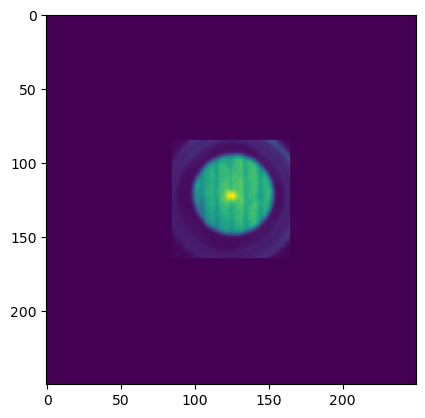

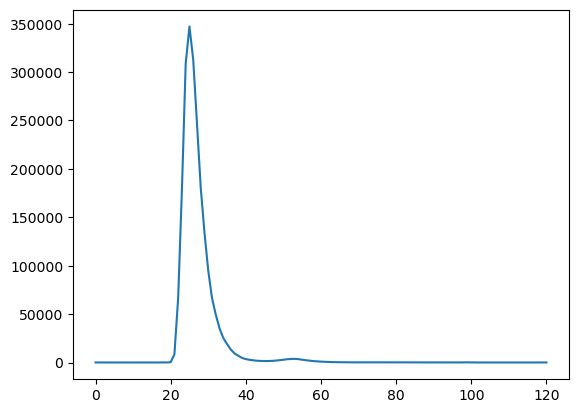

In [4]:

# %% get the sensitivity map and the IRF
data_fold = r'F:/OneDrive/UK_projects_local/project in UK 2024\diffuse_experiment241021/zhiguan_data/XL_measurement_061224'

#-----------------prepare the sensitibity map-------------
sens_path = os.path.join(data_fold,r'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy')
sensitivity = np.load(sens_path).sum(2)
sensitivity = sensitivity/sensitivity.max()
sensitivity = np.fliplr(sensitivity)
sensitivity = resize(sensitivity, (80,80), interpolation=cv2.INTER_LINEAR)
sens_pad = np.zeros((250,250))
sens_pad[125-40:125+40, 125-40:125+40] = sensitivity

plt.figure()
plt.imshow(sens_pad)
plt.show()

#-----------------prepare the IRF---------------------
IRF_path = os.path.join(data_fold,r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')
IRF = np.load(IRF_path)[:1000]
IRF_down = resize(IRF[:np.round(121*100/15).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
IRF_down= np.squeeze(IRF_down)
plt.plot(IRF_down)

sim_len = 121

src_x_positions = np.linspace(125+25,125-25,3) # from PMT view, from right to left
src_y_positions = np.linspace(125+25,125-25,3) # from PMT view, from up to down

#--------------MCX cfg------------------
try:
    cfg.clear()
except NameError:
    pass  
    
cfg = {'nphoton': 1e7, 
       'tstart':0, 
       
        'tend':sim_len*1e-10, 
        'tstep':0.1e-9, # 100 ps resolution
       'srcpos': [10,125,0], 
       'srcdir':[0,0,1],
       'unitinmm':1,
       # 'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
       'issavedet':1,
       'issaveref':1
       }

 
# cfg['prop'] = [[0,0,1,1],           # background
#                [0.0019, 1.4800,0,1.44], # volume 1
#                ]

# 20260128 new parameters
cfg['prop'] = [[0,0,1,1],           # background
               [0.002281, 1.5046, 0, 1.4595], # volume 1
               ]

## sim loop

In [5]:
current_date = datetime.now().strftime("%d%m%y") 
save_dir = f'F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/data_{current_date}'
os.makedirs(save_dir, exist_ok=True)
gd_path = os.path.join(save_dir, 'ds_objs_50x50_5x5cm.npy')
sims_result_path = os.path.join(save_dir, 'batch_mcx_sims_results.npy')
checkpoint_json = os.path.join(save_dir, 'checkpoint.json')

total_count = NUM_TOTAL # total number of samples from the dataset
save_interval = 100  # save every 100 sims

start_index = 0

# 1. check for existing checkpoint
if os.path.exists(checkpoint_json) and os.path.exists(gd_path) and os.path.exists(sims_result_path):
    print("found check point, reloading...")
    
    # redad checkpoint
    with open(checkpoint_json, 'r') as f:
        ckpt = json.load(f)
        start_index = ckpt['last_index'] + 1 # start from next index
        
    # load saved big data file (Loading to RAM)
    ground_truths = np.load(gd_path)
    sim_results = np.load(sims_result_path)
    
    print(f"successful loading, start from {start_index} ")
else:
    print("no checkpoint, restart...")
    start_index = 0
    ground_truths = np.zeros((50, 50, total_count), dtype=np.float32) # 
    sim_results = np.zeros((3, 3, sim_len, total_count), dtype=np.float32)

# ================= main loop =================
if start_index < total_count:

    display(disp_region)
    with disp_region:

        # range start from  start_index
        for img_index in tqdm(range(start_index, total_count), initial=start_index, total=total_count):

            # ---------------- start processing ----------------
            img, lab = subset_ds[img_index]  

            img = np.fliplr(np.rot90(img.squeeze(),k = -1,axes = (0,1))) # rotate to the normal vew

            img = cv2.copyMakeBorder(
                img, top=2, bottom=2, left=2, right=2,  
                borderType=cv2.BORDER_CONSTANT, value=0   
            )
            
            img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_NEAREST)
            
            threshold = 0
            img[img<=threshold]=0
            img[img>threshold]=1
            img = 1-img
            
            #=============this if for the flipped MNIST dataset===================
            img = np.fliplr(img)
            #==============this is for the flipped MNIST dataset===================

            plt.figure()
            plt.imshow(img, cmap='gray')
            plt.show()
            
            # save ground_truths
            ground_truths[:,:,img_index] = img
        
            obj_in_mcx_PMT_padding = cv2.copyMakeBorder(
                img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=1
            )
            obj_in_mcx_PMT_padding = np.uint8(obj_in_mcx_PMT_padding)
            
            # MCX Volume setup
            thickness = 50 
            unitinmm = 1
            t_vox = int(thickness/unitinmm)
            vol = np.ones([250,250,t_vox+1],dtype='uint8')
            vol[:,:,-1] = 0
            vol[:,:,24] = np.rot90(obj_in_mcx_PMT_padding,k = -1,axes = (0,1)) 
            cfg['vol'] = vol

            sim_mea = np.zeros((3,3,sim_len))
            
            # Scanning loop
            for i, pos_y in enumerate(src_y_positions):
                for j, pos_x in enumerate(src_x_positions):
                    cfg['srcpos'] = [pos_x, pos_y, 0]
                    res = pmcx.run(cfg)
                    dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:] 
                    dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1)) 
                    sim_mea[i,j,:] = (dref_bd_rot*sens_pad[:,:,None]).sum((0,1)) 
                        
            sim_mea = np.apply_along_axis(lambda m: fftconvolve(m, IRF_down, mode='full'), axis=2, arr=sim_mea)[:,:,:sim_len]
            sim_mea = sim_mea/sim_mea.max()
            
            # 存入 sim_results
            sim_results[:,:,:,img_index] = sim_mea
            
            # ---------------- Checkpoint save ----------------
            # evert save_interval, or the last one
            if (img_index + 1) % save_interval == 0 or (img_index + 1) == total_count:
                print(f"\nCheckpoint: Saving data at index {img_index}...")
                
                # 1. save big data files (NumPy)
                np.save(gd_path, ground_truths)
                np.save(sims_result_path, sim_results)
                
                # 2. save checkpoint (JSON)
                with open(checkpoint_json, 'w') as f:
                    json.dump({'last_index': img_index}, f)
                    
                print("Saved.")

print("All Done!")


no checkpoint, restart...


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

All Done!


## check the objs

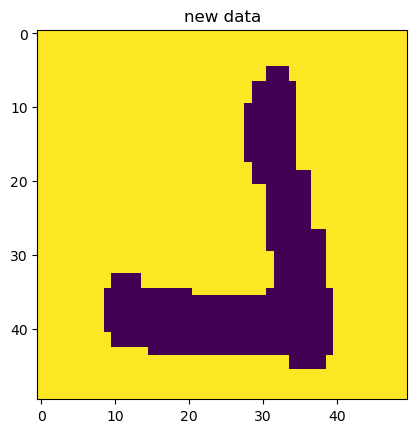

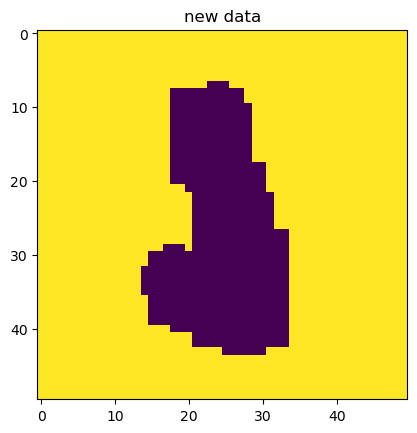

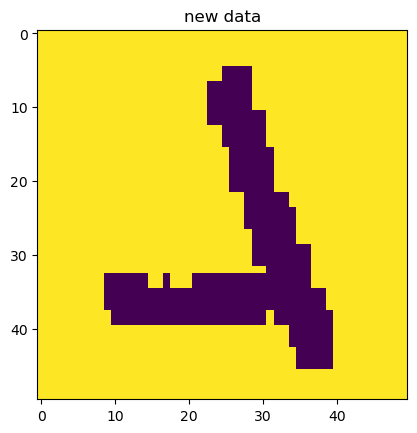

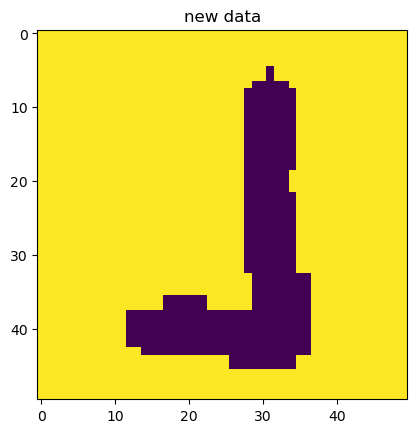

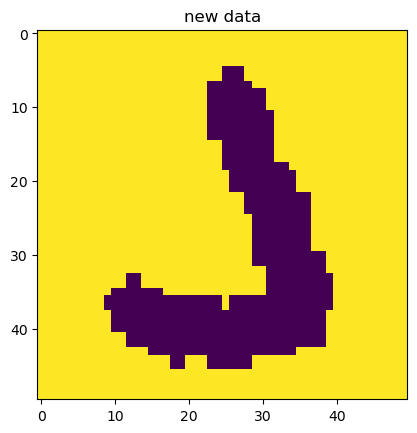

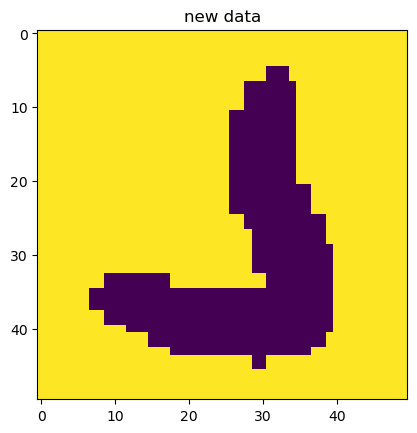

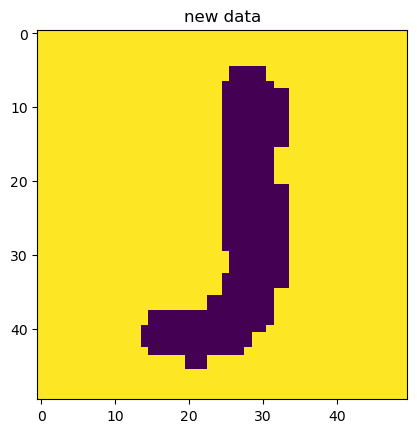

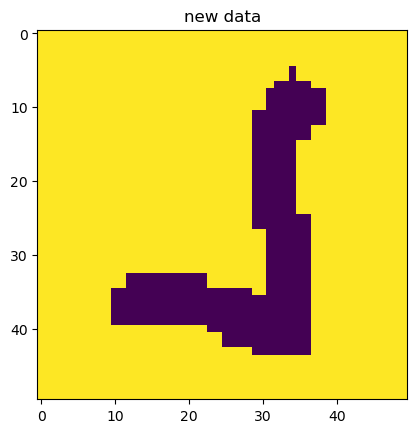

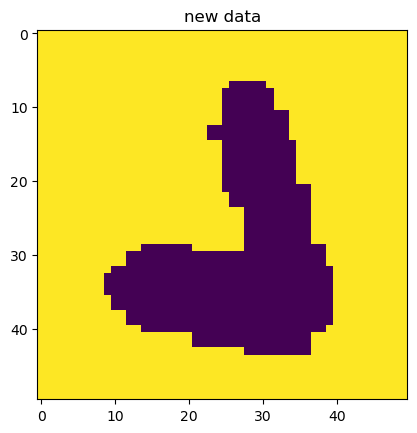

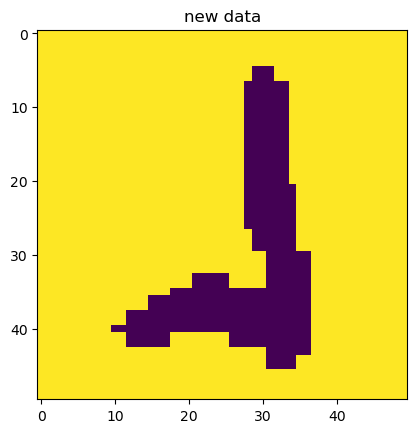

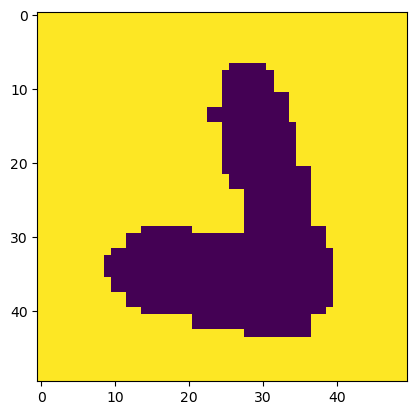

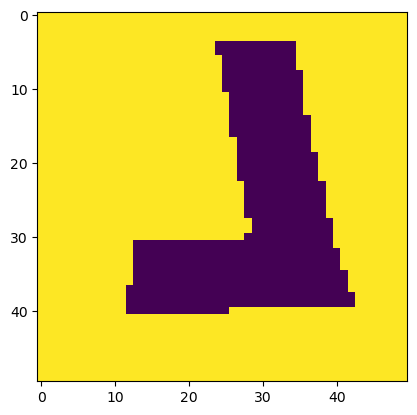

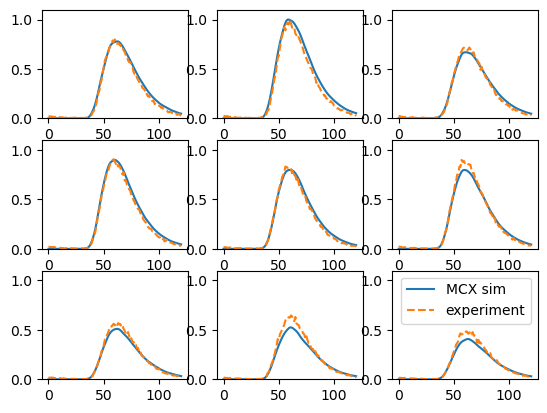

In [1]:
import numpy as np
import matplotlib.pyplot as plt


gd2 = np.load("F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/data_051225/ds_objs_50x50_5x5cm.npy")
gd1 = np.load("F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/data_051225/batch_mcx_sims_results.npy")

real_exp = np.load("F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/exp_real_L_3x3_data.npy")
real_obj = np.load('F:/OneDrive/foam_imaging_project/MF_forward/saved_data/obj_l_5x5cm_50x50_PMT_view.npy')

for i in range(0,1000,100):
    plt.figure()
    # plt.subplot(1,2,1)
    # plt.imshow(gd1[:,:,i])
    # plt.title('old data')
    # plt.show()
    # plt.subplot(1,2,2)
    plt.imshow(gd2[:,:,i])
    plt.title('new data')
    plt.show()

plt.figure()
plt.imshow(gd2[:,:,800])
plt.show()


plt.figure()
plt.imshow(real_obj)
plt.show()

# for i in range(0,1000,100):
#     img, lab = subset_ds[i]
#     plt.figure()
#     plt.imshow(img.squeeze())
#     plt.show()

plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.plot(gd1[i,j,:,800],label='MCX sim')
        plt.plot(real_exp[i,j,:], '--',label='experiment')  
        plt.ylim([0,1.1])
plt.legend()
plt.show()

np.save("F:/OneDrive/foam_imaging_project/MF_forward/saved_data/ds_flip_L_ind_800_5x5cm_50x50.npy",gd2[:,:,800])
np.save("F:/OneDrive/foam_imaging_project/MF_forward/saved_data/mcx_sim_ds_flip_L_ind_800.npy",gd1[:,:,:,800])

## noabs for difference

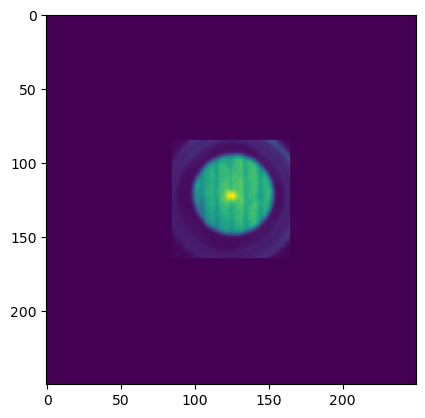

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


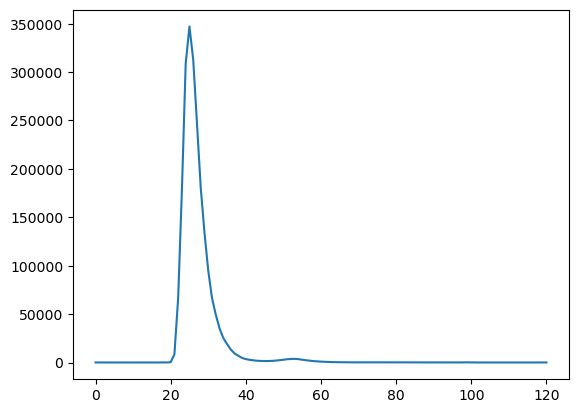

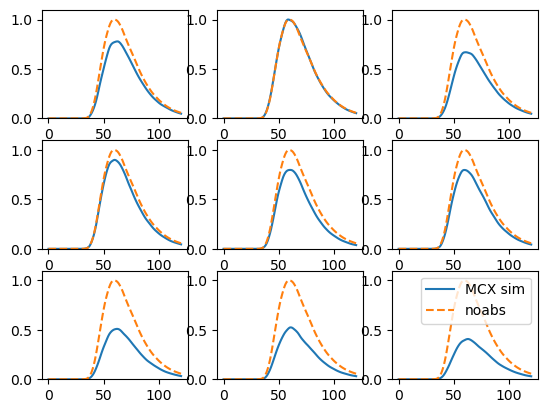

In [19]:
import pmcx
from scipy.signal import fftconvolve

# %% get the sensitivity map and the IRF
data_fold = r'F:/OneDrive/UK_projects_local/project in UK 2024\diffuse_experiment241021/zhiguan_data/XL_measurement_061224'

#-----------------prepare the sensitibity map-------------
sens_path = os.path.join(data_fold,r'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy')
sensitivity = np.load(sens_path).sum(2)
sensitivity = sensitivity/sensitivity.max()
sensitivity = np.fliplr(sensitivity)
sensitivity = cv2.resize(sensitivity, (80,80), interpolation=cv2.INTER_LINEAR)
sens_pad = np.zeros((250,250))
sens_pad[125-40:125+40, 125-40:125+40] = sensitivity

plt.figure()
plt.imshow(sens_pad)
plt.show()

#-----------------prepare the IRF---------------------
IRF_path = os.path.join(data_fold,r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')
IRF = np.load(IRF_path)[:1000]
IRF_down = cv2.resize(IRF[:np.round(121*100/15).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
IRF_down= np.squeeze(IRF_down)
plt.plot(IRF_down)

sim_len = 121

src_x_positions = 125 # from PMT view, from right to left
src_y_positions = 125 # from PMT view, from up to down

#--------------MCX cfg------------------
try:
    cfg.clear()
except NameError:
    pass  
    
cfg = {'nphoton': 1e7, 
       'tstart':0, 
       
        'tend':sim_len*1e-10, 
        'tstep':0.1e-9, # 100 ps resolution
       'srcpos': [10,125,0], 
       'srcdir':[0,0,1],
       'unitinmm':1,
       # 'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
       'issavedet':1,
       'issaveref':1
       }


cfg['prop'] = [[0,0,1,1],           # background
               [0.0019, 1.4800,0,1.44], # volume 1
               ]



# MCX Volume setup
thickness = 50 
unitinmm = 1
t_vox = int(thickness/unitinmm)
vol = np.ones([250,250,t_vox+1],dtype='uint8')
vol[:,:,-1] = 0
cfg['vol'] = vol

sim_mea = np.zeros((1,1,121))
cfg['srcpos'] = [125, 125, 0]
res = pmcx.run(cfg)
dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:] 
dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1)) 
sim_mea[0,0,:] = (dref_bd_rot*sens_pad[:,:,None]).sum((0,1)) 
            
sim_mea = np.apply_along_axis(lambda m: fftconvolve(m, IRF_down, mode='full'), axis=2, arr=sim_mea)[:,:,:sim_len]
sim_mea = sim_mea/sim_mea.max()
sim_mea = np.tile(sim_mea, (3, 3, 1))

plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        plt.plot(gd1[i,j,:,800],label='MCX sim')
        plt.plot(sim_mea[i,j,:], '--',label='noabs')  
        plt.ylim([0,1.1])
plt.legend()
plt.show()

np.save("F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/MCX_noabs_3x3_4_diff", sim_mea)
